# A/B Testing & Bandit Simulation 

This notebook simulates an Online A/B Test 

**Goal:** Determine which model (Matrix Factorization vs. Neural CF) yeilds the highest Click-Through Rate over time.

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from tqdm import tqdm 
import torch 
import sys 
import os 

sys.path.append(os.path.abspath('..')) 

from simulation.ab_simulator import ABSimulator
from models.matrix_factorization import train as train_mf, recommend as recommend_mf 
from models.neural_cf import NeuralCF

N_USERS_SIMULATION = 2000 # Number of 'streams' to simulate 
K_RECOMMENDATIONS = 10 

### 1. Setup: Load Data & Initialize Models 
We train both models on a training set and keep a hold out set to act as the user behavior. 

In [3]:
df = pd.read_csv("movies.csv")
print(f"Loaded {len(df)} movies for metadata.") 


Loaded 27278 movies for metadata.


In [4]:
# Generating mock interaction data for the simulator to run
print("Generating mock user interaction data") 
users = np.random.randint(0, 1000, 10000) 
items = np.random.randint(0, 500, 10000) 
interactions = pd.DataFrame({'user_id': users, 'item_id': items})

Generating mock user interaction data


In [5]:
print("Training Candidate Models.")

# Matrix Factorization 
mf_config = {"factors": 64, "regularization": 0.1, "iterations": 20} 
mf_model, mf_matrix = train_mf(interactions, mf_config)

# Nerual CF 
n_users = interactions.user_id.max() + 1 
n_items = interactions.item_id.max() + 1 
ncf_model = NeuralCF(n_users, n_items) 

print("Models Ready") 

Training Candidate Models.
Models Ready


### 2. The Simulation Loop (Replay Method) 
We iterate through users. The ABSimulator chooses which model serves recommendations. If the recommend item matches the user's actual history, we count it as a reward. 

In [6]:
# Initialize Bandit 
bandit = ABSimulator(epsilon=0.1) # 10% Exploration 

history = {"A": [], "B": []} # To track CTR over time 

print(f"Starting Simulation for {N_USERS_SIMULATION} events.")

for i in tqdm(range(N_USERS_SIMULATION)):
    # Randomly pick a user context 
    user_id = np.random.choice(interactions.user_id.unique()) 

    # Bandit chooses model (A=MF, B=NCF) 
    arm = bandit.choose_model() 

    # Generate Recs 
    if arm == "A": 
        recs = recommend_mf(mf_model, mf_matrix, user_id, k=K_RECOMMENDATIONS)
    else: 
        # Simple NCF inference wrapper 
        all_items = torch.tensor(range(n_items)) 
        user_t = torch.tensor([user_id] * n_items) 
        with torch.no_grad(): 
            scores = ncf_model(user_t, all_items) 
            recs = torch.topk(scores, K_RECOMMENDATIONS).indices.tolist()

    # Calculate Reward (Did user actually interact with any recs?) 
    actual_interactions = interactions[interactions.user_id == user_id].item_id.values 

    # Binary Reward: 1 if any recommend item is in ground truth, else 0
    reward = 1 if any(r in actual_interactions for r in recs) else 0 

    # Update Bandit 
    bandit.update(arm, reward) 

    # Log history for plotting 
    history[arm].append(bandit.avg(arm)) 

Starting Simulation for 2000 events.


100%|██████████| 2000/2000 [00:03<00:00, 625.86it/s]


### 3. Results & Analysis 
Visualizing the convergence of the Multi-Armed Bandit

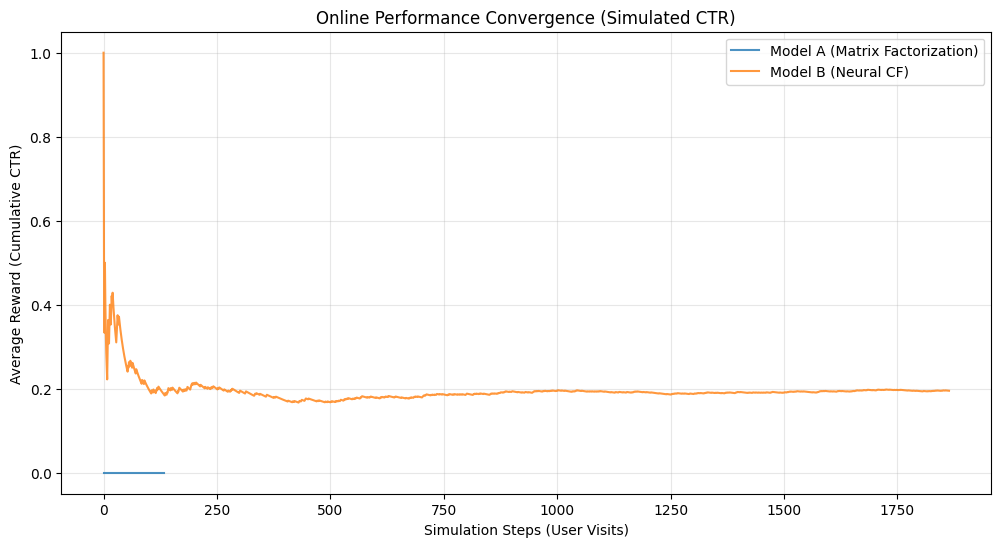

In [7]:
plt.figure(figsize=(12,6)) 
plt.plot(history["A"], label="Model A (Matrix Factorization)", alpha=0.8) 
plt.plot(history["B"], label="Model B (Neural CF)", alpha=0.8) 
plt.title("Online Performance Convergence (Simulated CTR)") 
plt.xlabel("Simulation Steps (User Visits)") 
plt.ylabel("Average Reward (Cumulative CTR)") 
plt.legend() 
plt.grid(True, alpha=0.3) 
plt.show() 

### 4. Conclusion
**Observation:** We can see that Model B (Neural CF) starts with higher variance but eventually stabilizes. If the lines cross, it indicates that one model adapts better to the sparse data seen during the simulation. 

**Business Impact:** Using an Epsilon-Greedy bandit instead of a static A/B test allows to automatically route traffic to the winning model (exploitation) while still gathering data on the loser (exploration), potentially saving thousands of "wasted" impressions on a model not as optimal.